# K-Nearest Neighbors (KNN)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Vamos a empezar con un problema muy sencillo, uno de los problemas de clasificación más famosos que existen. Fue propuesto por R.A. Fisher en 1936, y consiste en clasificar plantas de la especie *Iris* en tres subespecies: *iris-virginica*, *iris-setosa* e *iris-versicolor*. Los atributos que describen cada planta son las dimensiones (longitud y anchura) del pétalo y el sépalo. El conjunto de datos contiene un total de 150 plantas, 50 de cada una de las clases.

En la siguiente celda cargamos los datos del problema, que están incluidos en el paquete *sklearn.datasets*. En este enlace tienes una descripción de los datos:

https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

La variable ``iris`` es un diccionario con los siguientes elementos:

- ``data``: array de numpy con los datos del problema (no incluye la clase). Cada fila es un ejemplo (150), cada columna es un atributo (4).
- ``target``: array de numpy con las clases de los 150 ejemplos, cada clase es un número entre 0 y 2.
- ``target_names``: array de numpy con los nombres de las 3 clases.
- ``DESCR``: string con una descripción del problema.
- ``feature_names``: lista con los nombres de los 4 atributos.
- ``filename``: nombre del fichero que contiene los datos.

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Creamos un DataFrame con los datos para que sea más fácil visualizarlos:

In [ ]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target_names[iris.target]
df['target_num'] = iris.target
df[::10].head(15)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_num
0,5.1,3.5,1.4,0.2,setosa,0
10,5.4,3.7,1.5,0.2,setosa,0
20,5.4,3.4,1.7,0.2,setosa,0
30,4.8,3.1,1.6,0.2,setosa,0
40,5.0,3.5,1.3,0.3,setosa,0
50,7.0,3.2,4.7,1.4,versicolor,1
60,5.0,2.0,3.5,1.0,versicolor,1
70,5.9,3.2,4.8,1.8,versicolor,1
80,5.5,2.4,3.8,1.1,versicolor,1
90,5.5,2.6,4.4,1.2,versicolor,1


**Objetivo del problema**

Tenemos un conjunto de flores que hemos analizado, estudiado y clasificado en tres tipos distintos. Queremos definir un modelo de Machine Learning que, cuando vengan nuevas flores, sea capaz de clasificarlas automáticamente sin necesidad de ningún experto. Concretamente, vamos a utilizar el algoritmo K-Nearest-Neighbors, un algoritmo sencillo que clasifica según los datos que sean más próximos.

Antes de empezar, vamos a generarnos un dataset ficticio a partir de los datos de entrenamiento. Esto lo hacemos para evaluar si el modelo lo ha hecho correctamente o no con datos que no conocemos. Vamos a suponer que nuestros datos van a seguir una distribución normal. Por tanto, si tenemos dichas distribuciones, podemos generar datos aleatorios nuevos.

In [ ]:
means = df.groupby("target").mean()[iris.feature_names]
means

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


In [ ]:
stds = df.groupby("target").std()[iris.feature_names]
stds

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
setosa,0.352490,0.379064,0.173664,0.105386
versicolor,0.516171,0.313798,0.469911,0.197753
virginica,0.635880,0.322497,0.551895,0.274650


In [ ]:
N = 100 # Nuevos datos por cada clase
new_data = np.zeros((N*3, 4))
new_data_target = []

for i, target in enumerate(iris.target_names):
    for j, feature in enumerate(iris.feature_names):
        new_data[i*N:(i+1)*N, j] = np.random.randn(N) * stds.loc[target, feature] + means.loc[target, feature]
    new_data_target += [i]*N

new_data_target = np.array(new_data_target)

Las variables `new_data` y `new_data_target` las utilizaremos para **evaluar** cómo lo hace el modelo.

In [ ]:
print(new_data.shape, new_data_target.shape)

(300, 4) (300,)


Las variables `x` y `target` las utilizaremos para **entrenar** el modelo.

In [ ]:
x = df[iris.feature_names].values
target = df["target_num"].values
print(x.shape, target.shape)

(150, 4) (150,)


## Ejercicio 1: Un K-NN desde cero
Vamos a desarrollar un knn que funcione sobre Arrays de numpy. Para eso necesitamos.
 - Una función que calcule la distancia euclidea entre todos los puntos
 - Una clase que calcule la predicción y la predicción probabilística en función de los vecinos más cercanos


In [ ]:
def euclidean_distance(p, puntos):
    """
    Completar asumiendo que:
      p es un np.array con shape (4,) --> (1, 4)
      puntos es un np.array con shape (150, 4)
    """
    return np.sqrt(np.sum((p[None, :] - puntos)**2, axis=-1))

In [ ]:
matriz_distancias = [euclidean_distance(xi, x) for xi in x]

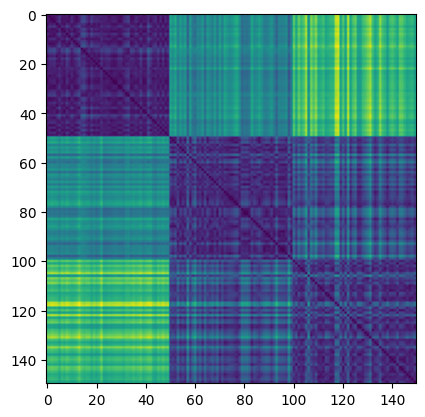

In [ ]:
plt.imshow(matriz_distancias)
plt.show()

In [ ]:
class miKNN():
    """
    k: parametro de vecinos mas cercanos
    x: Datos de train
    Y: Etiquetas de train
    """
    def __init__(self, k, x, y):
        self.k = k
        self.x = x
        self.y = y
        self.num_clases = len(np.unique(y))

    def predict_proba(self, new_x):
        """
        Calcula la proporcion Kc/K de cada punto en new_x
        """
        matriz_distancias = np.array([euclidean_distance(xi, self.x) for xi in new_x])
        indices = np.argsort(matriz_distancias)
        indices = indices[:, :self.k]
        clases = self.y[indices]
        probs = np.zeros((len(new_x), self.num_clases))
        for c in range(self.num_clases):
          probs[:, c] = (clases == c).mean(axis=1)
        return probs

    def predict(self, new_x):
        """
        A partir de las probabilidades de cada clase, calcula la clase ganadora
        """
        probs = self.predict_proba(new_x)
        return np.argmax(probs, axis=1)

    def score(self, new_x, new_y):
        """
        A partir de la clase ganadora, calcula el accuracy
        """
        preds = self.predict(new_x)
        return (preds == new_y).mean()

In [ ]:
knn = miKNN(5, x, target)

In [ ]:
probs = knn.predict_proba(x)
probs

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. 

In [ ]:
preds = knn.predict(x)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
knn.score(x, target)

0.9666666666666667

No lo estamos haciendo bien. Tenemos que evaluar sobre un conjunto de datos que no ha visto para calcular las distancias.

In [ ]:
preds = knn.predict(new_data)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [ ]:
knn.score(new_data, new_data_target)

0.9533333333333334

# Ejercicio 2
Verificar el resultado utilizando la implementación de knn en sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5) # Por defecto utiliza la distancia minkowski con p = 2, es decir, la distancia euclidea
knn.fit(x, target)

KNeighborsClassifier()

In [ ]:
knn.score(x, target)

0.9666666666666667

In [ ]:
knn.score(new_data, new_data_target)

0.9533333333333334